 # <center> Digit recognition using SVD
 <h3 align="center">Scientific Computing 1402-1403 spring</h3>
<h3 align="center">Darya Ansaripour-610300022, Amir Faridi-610300087</h3>


# Introduction
This project consists of 3 different mathemathical approaches for recognizing digits based on norms and SVD.
We will compare them in terms of both efficiency and accuracy.
The dataset used in the project is *mnist* which contains 10000 labaled images of handwritten digits as train data and 60000 as test.

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import time
(x_train,y_train), (x_test,y_test) = mnist.load_data()

# First approach
The easiest way to determine the digit using Its matrix representation is to match Its flatten with the nearest number in trainset in term of their 2-norm. This is the idea of this approach, we simply find $ min \lbrace \lVert a_{i}-b \rVert _{2} \rbrace $ where $a_{i}$ is the i-th train image and $b$ is the test image and finally take its label as the digit corressponding to our test.
As Its observable, It takes about 19ms to find the minimum among the train data set, which is inefficient comparing with other methods which we will discuss furthur.

In [20]:
x_train1 = x_train[:2000]
y_train1 = y_train[:2000]
x_test1 = x_test[:1000]
y_test1 = y_test[:1000]
M = 1000
s = time.time()
accuracy = np.sum([1*(y_train1[np.argmin([np.linalg.norm(x_train1[i].flatten()/255 - x_test1[j].flatten()/255) for i in range(len(x_train1))])]==y_test1[j]) for j in range(len(x_test1))])/len(y_test1)
e = time.time()
print(f"Accuracy: {accuracy*100} %")
print(f"Time: {(e-s)/M*1000:.3f}ms")

Accuracy: 87.3 %
Time: 19.515ms


# Second approach
Since the first approach needs a lot of resource, we try to modify by taking the mean vector of pictures in trainset related to each digit. We gather train images corresponding to a digit (using their labels) and create a matrix by taking the mean of cells and for test data, we just find the minimum among these 10 mean vectors. Obviously it is more efficient considering the time but it has lower accuracy.

(60000, 28, 28)
(60000,)


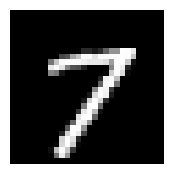

7


In [9]:
print(x_train.shape)
print(y_train.shape)

idx = np.random.randint(0, x_train.shape[0])
fig = plt.figure(figsize=(2, 2))
plt.imshow(x_train[idx], cmap='gray')
plt.axis('off')
plt.show()
print(y_train[idx])

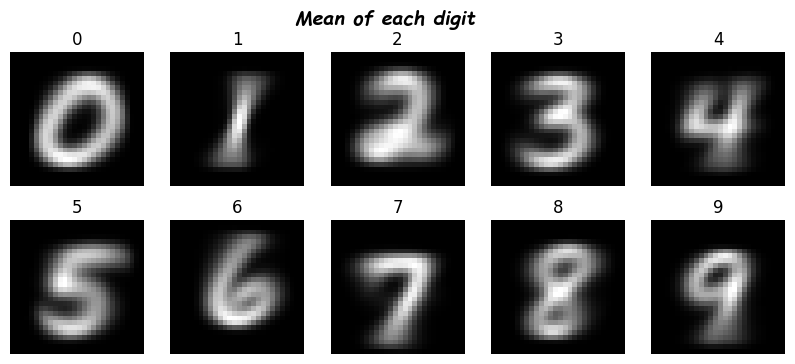

In [10]:
means = {}
for i in range(10):
    digit = x_train[y_train == i]
    means[i] = np.mean(digit, axis=0)


fig, axs = plt.subplots(2, 5)
fig.set_size_inches(10, 4)
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(means[i], cmap='gray')
    ax.set_title(i)
    ax.axis('off')
plt.suptitle('Mean of each digit', fontstyle='italic', fontsize=14, fontweight='bold', fontname = "Comic Sans MS")
plt.show()

Accuracy: 79.0 %
Time: 0.107ms
Number of incorrect predictions: 210


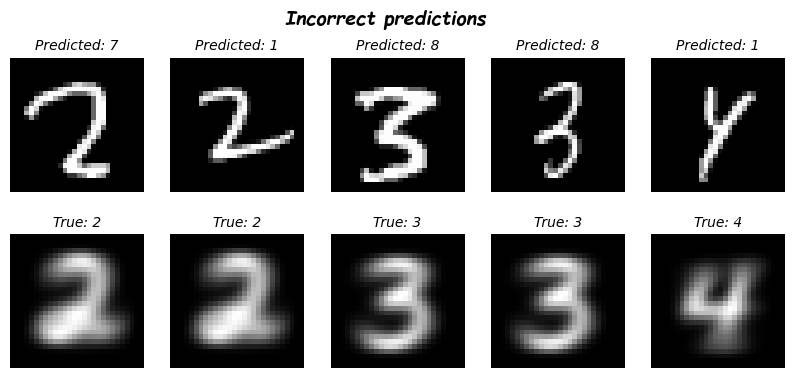

In [11]:
correct, total = 0, len(x_test)
incorrect = []
total_time = 0
MAX = len(x_test)
M = 1000
for i in range(M):
    distances = []
    start = time.time()
    for j in range(10):
        distances.append(np.sum((x_test[i] - means[j])**2))
    if np.argmin(distances) == y_test[i]:   correct += 1
    else:                                   incorrect.append(i)
    total_time += time.time() - start
print(f"Accuracy: {correct/M*100} %")
print(f"Time: {total_time/M*1000:.3f}ms")

print(f"Number of incorrect predictions: {len(incorrect)}")

N = min(5, len(incorrect))
np.random.shuffle(incorrect)
fig, axs = plt.subplots(2, N)
fig.set_size_inches(10, 4.2)
for i in range(N):
    ax = axs[0, i]
    ax.imshow(x_test[incorrect[i]], cmap='gray')
    ax.axis('off')
    ax.set_title(f"Predicted: {np.argmin([np.sum((x_test[incorrect[i]] - means[j])**2) for j in range(10)])}", fontsize=10, fontstyle='italic')
    ax = axs[1, i]
    ax.imshow(means[y_test[incorrect[i]]], cmap='gray')
    ax.axis('off')
    ax.set_title(f"True: {y_test[incorrect[i]]}", fontsize=10, fontstyle='italic')
plt.suptitle('Incorrect predictions', fontstyle='italic', fontsize=14, fontweight='bold', fontname = "Comic Sans MS")
plt.show()

# Third approach (using SVD)
As we know for each matrix there is a representation consisting of product of 3 matrices $ A = U \Sigma V^{*} $ where $U$ and $V$ are unitary and $\Sigma$ is a diagonal matrix consisting of $\sigma _{i}$ s, the singular values of $A$ sorted decreasing by their magnitude. Note that the columns of U are eigenvectors of $A^*A$ and those of $V$ are eigenvectors of $AA^*$ <br> 
Also as a corollary we have $A = \sigma _{1}u_{1}v_{1}^{*} + \sigma _{2}u_{2}v_{2}^{*} + ...+ \sigma _{n}u_{n}v_{n}^{*}$. <br>
We can define approximation matrix $A_{r} = \sigma _{1}u_{1}v_{1}^{*} + \sigma _{2}u_{2}v_{2}^{*} + ...+ \sigma _{r}u_{r}v_{r}^{*}$ and due to the lectures it is proven that $A_{r}$ is the best rank-r approximation for $A$. <br>
The training is as follows: <br>
1. First we collect all instances of a digit and we create a matrix $A$ by flattening them and using them as columns.
2. Second we construct the SVD of $A$ and select the first $r$ columns of $U$. 
3. Let z be an unknown test image, we try to give the best approximation of z by linear combination of $u_1, u_2,...,u_r$. In other words we try to solve a LSP as below: $$min{\lVert z-\Sigma^{r}_{i=1}y_iu_i \rVert _2} = min{\lVert z- U_ry \rVert _2} $$ 
which has the solution $y=U_r^*z$ and gives $U_rU_r^*z$ as the orthogonal projection of z on $<u_1,...,u_r>$.
4. The distance between $z$ and its projection $U_rU_r^*z$ tells how well $z$ can be approximated within the space.
define the relative residual as $\frac{\lVert z-U_rU_r^*z \rVert _2}{\lVert z \rVert _2}$
5. We choose the digit ($U_r$) which makes $\frac{\lVert z-U_rU_r^*z \rVert _2}{\lVert z \rVert _2}$ minimum as the final answer.


In [12]:
train_dict = { i : x_train[y_train == i] for i in range(10) }
digit_matrices = {}
for d, images in train_dict.items():
    flattened_images = [image.flatten() for image in images]
    digit_matrix = np.column_stack(flattened_images)
    digit_matrices[d] = digit_matrix

print(f"Digit {0} matrix shape: {digit_matrices[0].shape}")

Digit 0 matrix shape: (784, 5923)


In [13]:
SVD_results = {}
for d, mat in digit_matrices.items():
    U, S, Vt = np.linalg.svd(mat, full_matrices=False)
    SVD_results[d] = (U, S, Vt)

print(f"Digit {0} U shape: {SVD_results[0][0].shape}")
print(f"Digit {0} S shape: {SVD_results[0][1].shape}")
print(f"Digit {0} Vt shape: {SVD_results[0][2].shape}")

Digit 0 U shape: (784, 784)
Digit 0 S shape: (784,)
Digit 0 Vt shape: (784, 5923)


In [14]:
R = min(20, len(S))
U_Rs = { d : U[:, :R] for d, (U, S, Vt) in SVD_results.items()}
print(f"Digit {0} U_R shape: {U_Rs[0].shape}")

USV_Rs = { d : U_Rs[d] @ np.diag(S[:R]) @ Vt[:R, :] for d, (U, S, Vt) in SVD_results.items()}
print(f"Digit {0} USV_R shape: {USV_Rs[0].shape}")

Digit 0 U_R shape: (784, 20)
Digit 0 USV_R shape: (784, 5923)


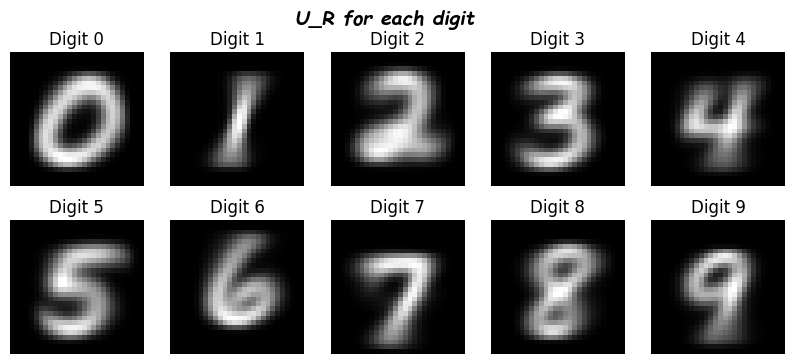

In [15]:
fig, axs = plt.subplots(2, 5)
fig.set_size_inches(10, 4)
for d in range(10):
    ax = axs[d//5, d%5]
    ax.imshow(255 - U_Rs[d][:, 0].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Digit {d}")
plt.suptitle('U_R for each digit', fontstyle='italic', fontsize=14, fontweight='bold', fontname = "Comic Sans MS")
plt.show()

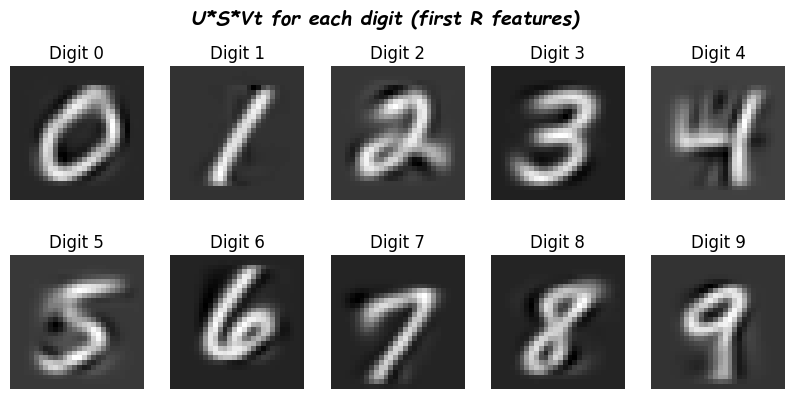

In [16]:
fig, axs = plt.subplots(2, 5)
fig.set_size_inches(10, 4.5)
for d in range(10):
    ax = axs[d//5, d%5]
    ax.imshow(USV_Rs[d][:, 0].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Digit {d}")
plt.suptitle('U*S*Vt for each digit (first R features)', fontstyle='italic', fontsize=14, fontweight='bold', fontname = "Comic Sans MS")
plt.show()

In [17]:
def run(r : int, flag : bool = False, N : int = 5):
    R = min(r, len(S))
    U_Rs = { d : U[:, :R] for d, (U, S, Vt) in SVD_results.items()}
    
    correct = 0
    incorrect = []
    total_time = 0
    MAX = len(x_test)
    M = 1000
    for i in range(M):
        z = x_test[i].flatten()
        min_norm = float('inf')
        min_d = -1
        start = time.time()
        for d, U_R in U_Rs.items():
            Ur = U_R @ U_R.T
            norm = np.linalg.norm(z - Ur @ z) / np.linalg.norm(z)
            if norm < min_norm:
                min_norm = norm
                min_d = d
        if min_d == y_test[i]:  correct += 1
        else:                   incorrect.append(i)
        total_time += time.time() - start

    print(f"Accuracy: {correct/M*100} %")
    print(f"Time: {total_time/M*1000:.3f}ms")

In [18]:
for i in range(5, 16, 5):
    run(r = i, flag = True)
    print("\n")

Accuracy: 89.9 %
Time: 22.675ms


Accuracy: 93.0 %
Time: 24.602ms


Accuracy: 94.0 %
Time: 26.105ms




# Refrences
1. Based on Chapter 10: Classification of Handwritten Digits from the book Matrix Methods in Data Mining and Pattern Recognition by Lars Elden, SIAM, Philadelphia, 2007
